In [1]:
import os
import io
import s3fs
import pandas as pd
import numpy as np
import seaborn as sns

import psycopg2
from sqlalchemy import create_engine

!pip install missingno
import missingno as msno

!pip install nltk
import nltk as nltk

%matplotlib inline

#variable pour les serveurs du projet
from settings import * 

Looking in indexes: https://nexus.beta.innovation.insee.eu/repository/pypi-public/simple
Looking in indexes: https://nexus.beta.innovation.insee.eu/repository/pypi-public/simple


Objectif : On essaye de reconcilier l'adresse de l'employeur d'un BI (Bulletin Individuel) au siret/siren contenu dans SICOR :

>Le numéro SIREN correspond à une série unique de 9 chiffres, attribuée par l’INSEE à chaque entreprise. Le numéro SIRET >correspond au numéro SIREN suivi de 5 chiffres correspondant à un Numéro Interne de Classement (NIC) propre à chaque >établissement de l’entreprise. Celle-ci aura un numéro SIREN et autant de NIC que d’établissements différents, c’est-à-dire un >seul numéro SIREN  et autant de SIRET que d’établissements/lieux d’exercice de son activité. Le numéro SIREN SIRET est mentionné >sur le Kbis (appelé « K » pour une entreprise individuelle), document officiel obtenu après l’immatriculation de l’entreprise et >attestant de sa légalité.



# 1 Etudions un BI

In [2]:
table_name = 'rp_final_2017'
engine = create_engine(F'postgresql://{user}:{password}@{host}:{port}/{dbname}')
sql = """
SELECT *
FROM rp_final_2017
LIMIT 10
"""
df_rp2014 = pd.read_sql(sql, con=engine);
df_rp2014.replace([None], np.nan, inplace=True)
#astuce pour infer les type
buffer = io.StringIO()
df_rp2014.to_csv(buffer,index=False,sep='~')
buffer.seek(0)
df_rp2014 = pd.read_csv(buffer,sep='~')
del buffer

In [3]:
print('nb lines : {}'.format(len(df_rp2014)))
df_rp2014.head()

nb lines : 10


,cabbi,rs_x,actet_c,actet_c_c,actet_x,nomvoi_x,numvoi_x,typevoi_x,bister_x,cpladr_x,...,naf4,pct4,naf5,pct5,nbtot,nb5,x,y,sourcexyw,qual
0,7350591563,MIGUEL SERVICES,4322A,3700Z,ELECTRICIEN PLAQUISTE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,398250.00,6770550.00,NaN,9.0
1,7350591562,MAITRE GUILLERON NOTAIRE,6910Z,6910Z,NOTAIRE,DU CLOS,2.0,PL,NaN,NaN,...,*****,NaN,*****,NaN,4848.0,4824.0,407050.00,6780350.00,158.113883,8.5
2,7300076862,CHEQUE EMPLOI SERVICE,9700Z,3700Z,AIDE A LA PERSONNE MENAGE,NaN,NaN,NaN,NaN,NaN,...,9499Z,10.0,8899B,10.0,10.0,8.0,706850.00,6557650.00,NaN,9.0
3,7300076772,IEMTHESE AGEPAPH,8710B,8710B,(CENTRE) INSTITUE D EDUCATION MOTRICE,DE SAULCET,73.0,RTE,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,721502.79,6579439.67,NaN,1.0
4,7300076915,ECOLE PRIMAIRE (VENSAT),8520Z,8411Z,ECOLE,NaN,NaN,NaN,NaN,NaN,...,*****,NaN,*****,NaN,4887.0,4309.0,714250.00,6549650.00,NaN,9.0


In [4]:
df_rp2014.nunique()

cabbi                 30876
typcol                    2
depcom_code            5341
rs_x                  23142
ilt_x                     2
vardompart_x              3
numvoi_x                586
bister_x                 12
typevoi_x                40
nomvoi_x              14770
cpladr_x                652
actet_x               12288
actet_c_c               654
actet_c                 684
clt_c_c                6807
clt_x                  6138
dlt_x                   200
plt_x                     5
siretc                21891
note_mca_adr_c            5
note_mca_nom_c          350
i_mca_c                   3
profi_x                1219
profs_x               10646
profa_x                 920
i_reprise_act             1
i_siret_m                 1
siret_dec             26820
siretm                25318
proces_codage_init        3
arbitrage                 5
siretq                22247
i_siret_q                 2
siret_arb              7184
x                     14762
y                   

#CABBI est supposé être l'identifiant, pas de doublons  
Toutes les variables contenant un '_x' sont les variables déclarés

In [5]:
df_declaration = df_rp2014.loc[:, df_rp2014.columns.str.contains('_x')]
print(df_declaration.columns)

Index(['rs_x', 'ilt_x', 'vardompart_x', 'numvoi_x', 'bister_x', 'typevoi_x',
       'nomvoi_x', 'cpladr_x', 'actet_x', 'clt_x', 'dlt_x', 'plt_x', 'profi_x',
       'profs_x', 'profa_x'],
      dtype='object')


In [6]:
df_declaration.head()

,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,cpladr_x,actet_x,clt_x,dlt_x,plt_x,profi_x,profs_x,profa_x
0,ROSTAN GAP,2.0,NaN,NaN,NaN,NaN,NaN,NaN,REPARATION D APPAREILS ELECTRIQUE,GAP,05,NaN,NaN,OUVRIER QUALIFIE,NaN
1,JAEGGI,1.0,2.0,NaN,NaN,NaN,NaN,NaN,EXPL AGRICOLE OLEICULTURE,NaN,NaN,NaN,AGRICULTRICE,NaN,NaN
2,LYCE PGDG DIGNE,2.0,NaN,NaN,NaN,NaN,ZI SAINT CHRISTOPHE,NaN,ENSEIGNEMENT,DIGNE LES BAINS,04,NaN,NaN,PROFESSEUR AGREGE,NaN
3,MAIRIE D'AIX,2.0,NaN,12.0,NaN,R,PIERRE ET MARIE CURIE,NaN,SERVICE PUBLIC,AIX EN PROVENCE,13,NaN,NaN,AGENT DE MAITRISE PRINCIPALE,NaN
4,CNRS,2.0,NaN,23.0,NaN,R,DES DIABLES BLEUS,NaN,RECHERCHE,NICE,NaN,NaN,NaN,CHERCHEUR,NaN


In [7]:
df_declaration.isna().sum()

rs_x              342
ilt_x            2078
vardompart_x    27417
numvoi_x        20788
bister_x        30496
typevoi_x       15131
nomvoi_x         8645
cpladr_x        30169
actet_x          2090
clt_x           11188
dlt_x           13605
plt_x           30841
profi_x         27930
profs_x          4877
profa_x         29282
dtype: int64

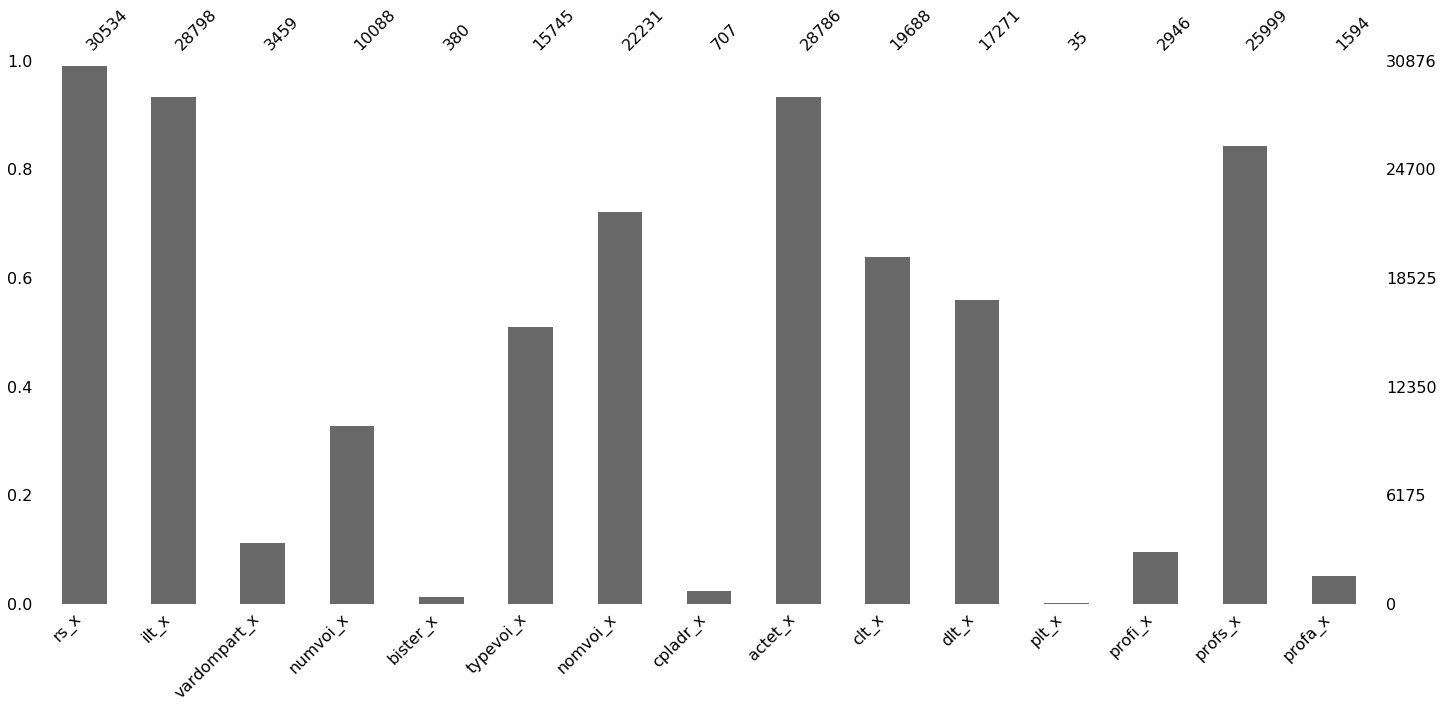

In [8]:
msno.bar(df_declaration)

Sur cet échantillon, le champs rs_x qui correspond au nom de l'établissement est quasi 100%.   
Actet_x activité économique aussi.   
~75% sur la localisation de l'entreprise

## 1.2 Score MCA

| Var |  nature | desc | commentaire
:-: |:-: | :-: | :-:
|SIRET_DEC | Calculée|Établissement de travail|Siret finalement conservé|  
|SIRETC|Codée|Établissement de travail codé automatiquement (siret)|Siret codé par MCA|  
|SIRETM|Codée|Établissement de travail en cours de codage manuel (siret)|Siret codé  par le gestionnaire|  


l'idée est d'exploré les scores MCA selon les catégories C, D et E et de voir si on peux les discriminer

In [9]:
df_label = df_rp2014[['siret_dec','siretc','siretm','note_mca_adr_c','note_mca_nom_c','i_mca_c']]

In [10]:
df_label.head()

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c
0,41056845500019,4.282680e+13,4.105685e+13,31.0,333.0,E
1,40326325400027,4.032633e+13,4.032633e+13,31.0,461.0,E
2,19040490500019,2.604036e+13,1.904049e+13,22.0,384.0,E
3,21130001700012,2.113000e+13,2.113000e+13,31.0,555.0,E
4,18008901303324,1.800890e+13,1.800890e+13,31.0,800.0,E


On regarde le % de siret mca directement approuvé

In [11]:
#perf MCA (1ère instance)
len(df_label[df_label.siret_dec == df_label.siretc]) / len(df_rp2014)

0.43901412100012954

On regarde le % de siret approuvé par un gestionnaire, n'est pas exclusif au MCA

In [12]:
#perf gestionnaire (si ça se passe mal)
len(df_label[df_label.siret_dec == df_label.siretm]) / len(df_rp2014)

0.9362935613421428

In [13]:
df_label.isna().sum()

siret_dec            0
siretc            5787
siretm            1967
note_mca_adr_c    5787
note_mca_nom_c    5787
i_mca_c           5787
dtype: int64

In [50]:
#check si on a score MCA sans siret MCA (pas possible normalement)
#garde-fou
df_label[(df_label.siretc.isnull()) & (~df_label.note_mca_adr_c.isnull())]

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c,mca_approved


In [51]:
df_label[(df_label.siretc.isnull()) & (~df_label.note_mca_nom_c.isnull())]

,siret_dec,siretc,siretm,note_mca_adr_c,note_mca_nom_c,i_mca_c,mca_approved


In [52]:
df_rp2014.i_mca_c.value_counts(dropna=False)

E      21759
NaN     5787
D       2341
C        989
Name: i_mca_c, dtype: int64

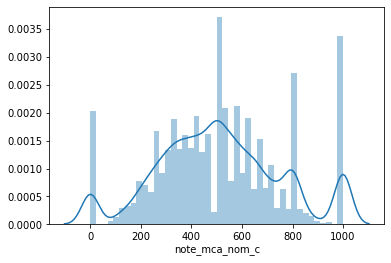

In [17]:
sns.distplot(df_label[df_label.note_mca_nom_c.notna()].note_mca_nom_c)

Valeur allant de 0 à 1000

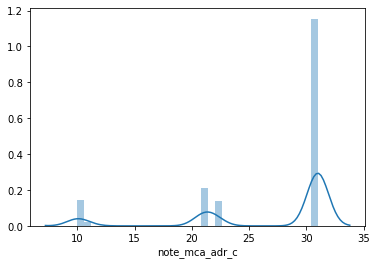

In [18]:
sns.distplot(df_label[df_label.note_mca_adr_c.notna()].note_mca_adr_c)

Distribution plus étrange des note adr

In [19]:
df_label['mca_approved'] = 0
df_label.mca_approved = df_label.apply(lambda x: 1 if x.siret_dec == x.siretc else 0, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


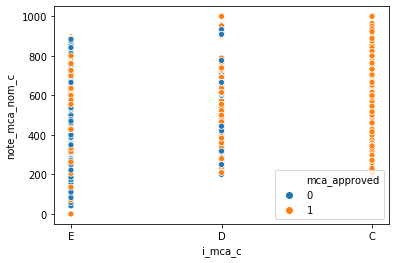

In [20]:
ax = sns.scatterplot(x="i_mca_c", y="note_mca_nom_c",hue="mca_approved", data=df_label)

On essaye de voir si les classe E, D et C ont une distribution particulière de score. MCA_approved signifie que l'echo mca a été approuvé (la distribution C est ceux qui sont passé en 1ère passe, logique de retrouvé 100% de mca_approved). La distribution D semble un peu plus haute.

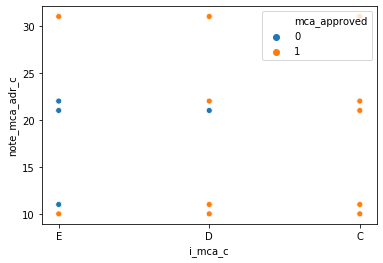

In [21]:
ax = sns.scatterplot(x="i_mca_c", y="note_mca_adr_c",hue="mca_approved", data=df_label)

mca_adr contenant moins de valeur potentielle, le graphique est moins lisible.

In [26]:
df_C_decl = df_rp2014[df_rp2014.i_mca_c == 'C']
df_C_decl_declaration = df_C_decl.loc[:, df_C_decl.columns.str.contains('_x')]

On va regarder les distribution de valeurs manquante en fonctione de la classe C, D et E

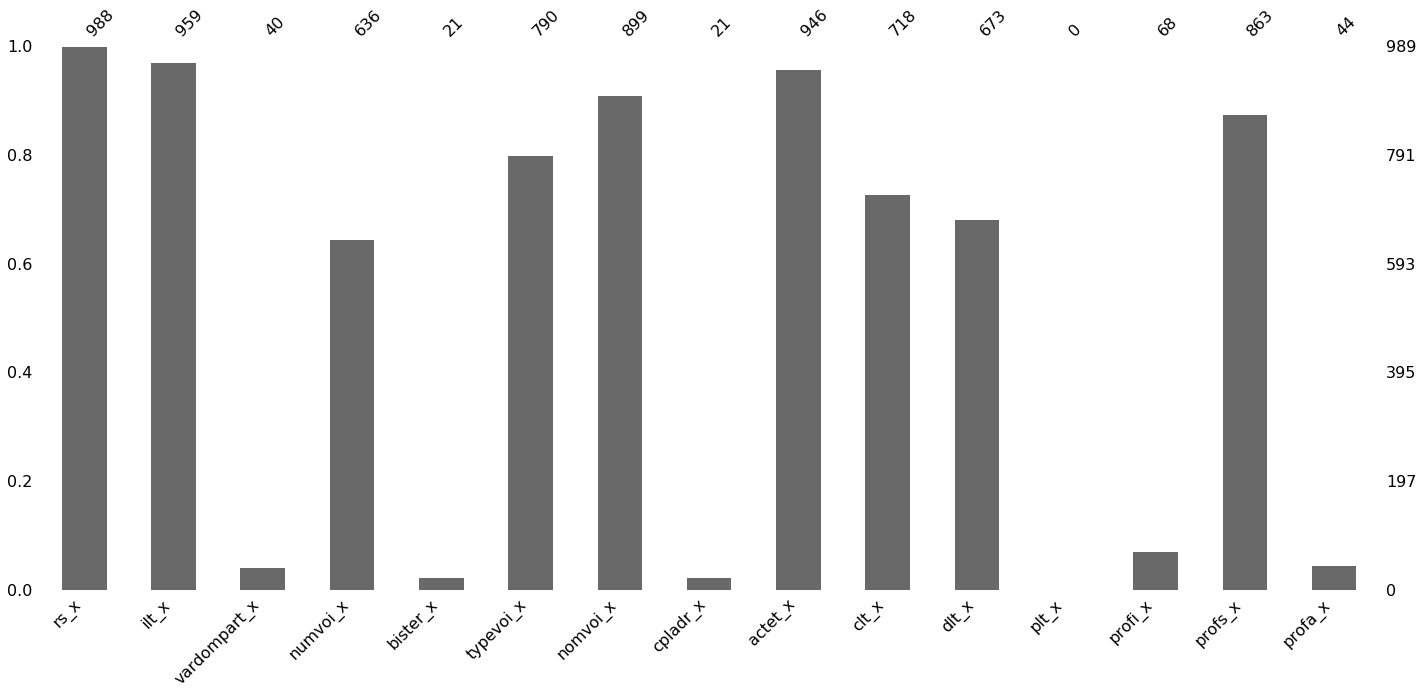

In [28]:
msno.bar(df_C_decl_declaration)

In [32]:
df_D_decl = df_rp2014[df_rp2014.i_mca_c == 'D']
df_D_decl_declaration = df_D_decl.loc[:, df_D_decl.columns.str.contains('_x')]

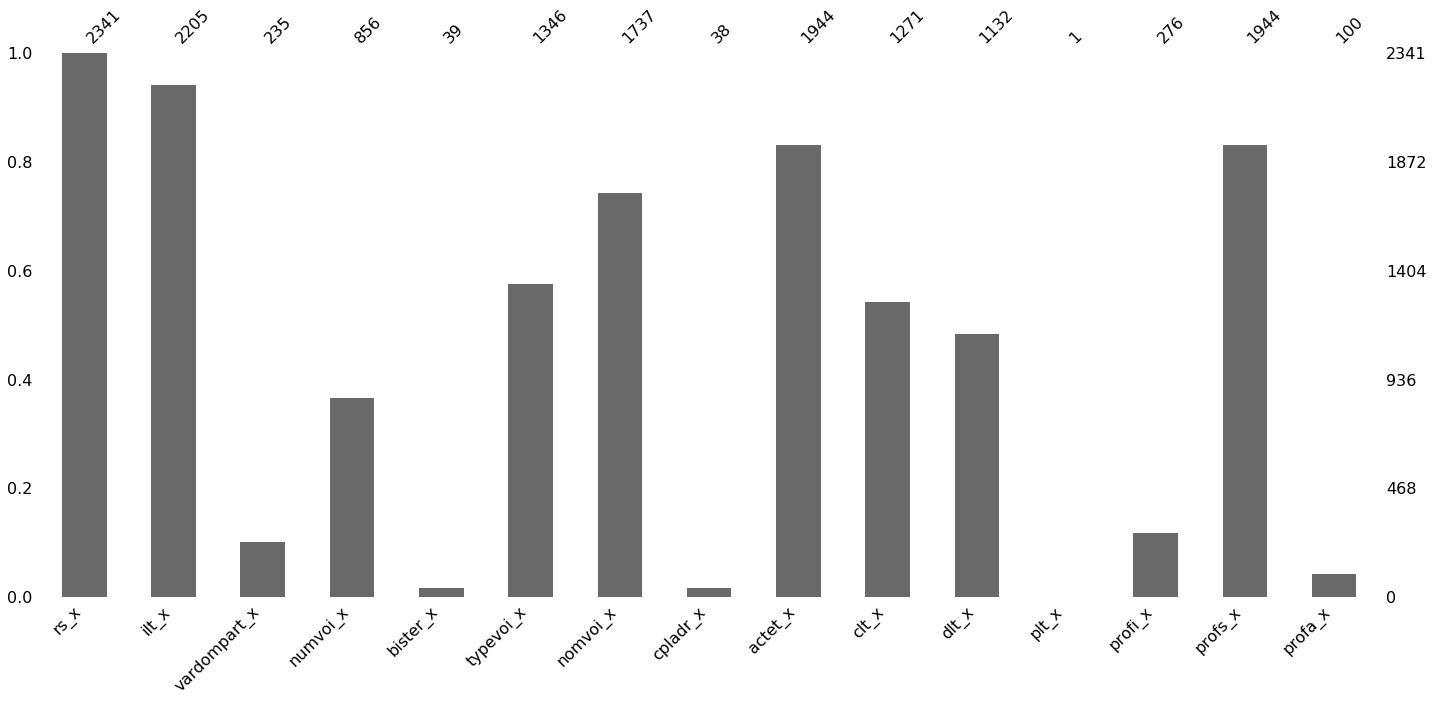

In [33]:
msno.bar(df_D_decl_declaration)

In [34]:
df_E_decl = df_rp2014[df_rp2014.i_mca_c == 'E']
df_E_decl_declaration = df_E_decl.loc[:, df_E_decl.columns.str.contains('_x')]

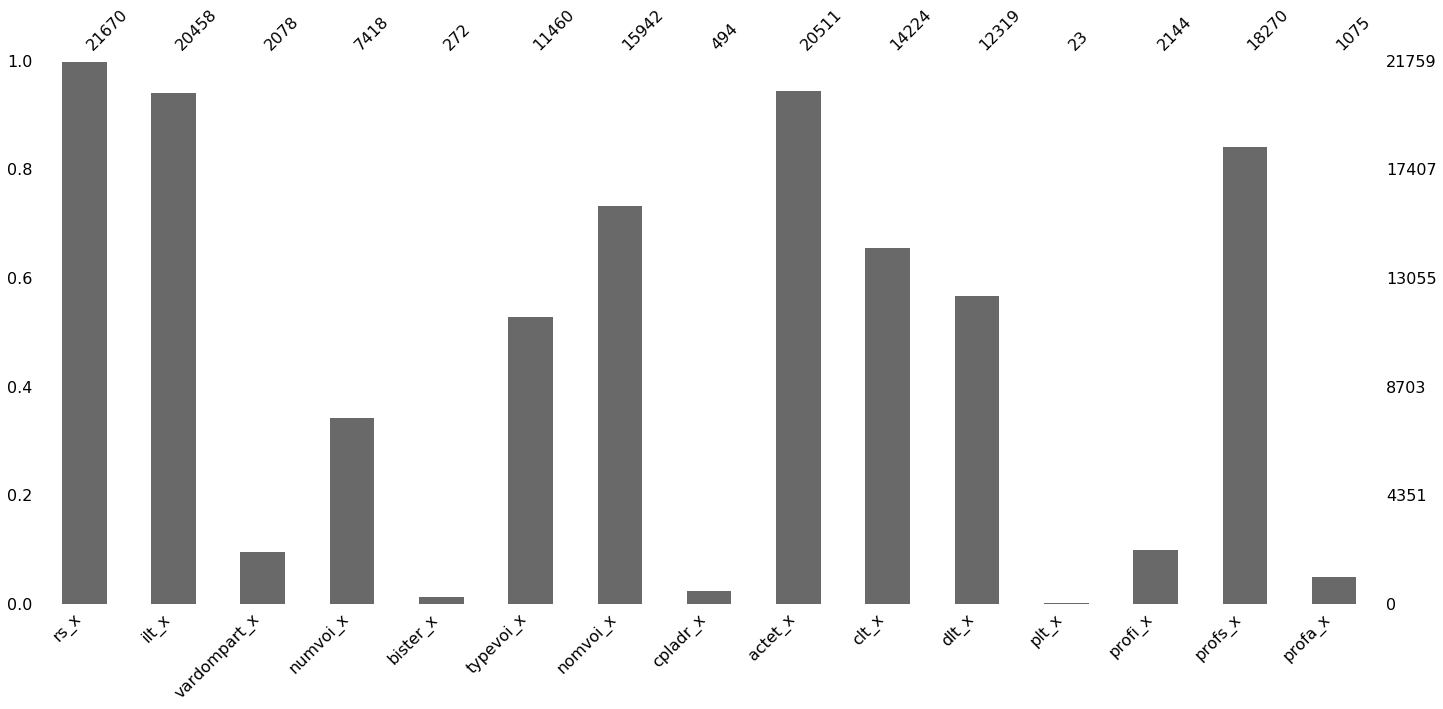

In [35]:
msno.bar(df_E_decl_declaration)

### 1.2 Profession
On veut voir si certaines profession sont plus difficile à traiter que d'autre (toujours selon les classe C D et E)

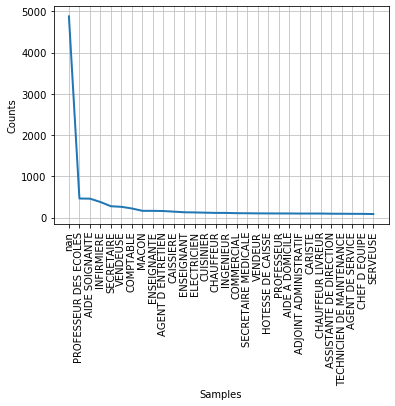

In [36]:
nltk.FreqDist(df_rp2014.profs_x.values).plot(30)

In [37]:
df_C_decl_declaration.profs_x.value_counts()

VENDEUSE                           12
COMPTABLE                          11
ASSISTANTE DE DIRECTION             9
CHAUFFEUR LIVREUR                   7
CHEF D EQUIPE                       7
                                   ..
EMPLOYEE LIBRE SERVICE              1
GESTIONNAIRE EN ASSURANCES          1
MANAGER CHEF DE SERVICE             1
ASSISTANTE DE GESTION               1
PROFESSEUR FORMATRICE D'ANGLAIS     1
Name: profs_x, Length: 661, dtype: int64

In [38]:
df_D_decl_declaration.profs_x.value_counts()

AIDE SOIGNANTE                                              78
INFIRMIERE                                                  71
SECRETAIRE                                                  27
SECRETAIRE MEDICALE                                         26
ADJOINT ADMINISTRATIF                                       24
                                                            ..
INFIRMIERE EN SOINS GENERAUX IDE B NES CLASSE SUPERIEURE     1
CHARGE DE MISSION QUALITE FILIERE TECHNIQUE CATEGORIE B      1
AGENT DE SERVICE EN CANTINE                                  1
FONCTION PUBLIQUE TERRITORIALE SECRETAIRE AU CCAS            1
RESPONSABLE D AFFAIRES                                       1
Name: profs_x, Length: 1201, dtype: int64

In [39]:
df_E_decl_declaration.profs_x.value_counts()

PROFESSEUR DES ECOLES                                           339
AIDE SOIGNANTE                                                  329
INFIRMIERE                                                      266
SECRETAIRE                                                      207
VENDEUSE                                                        191
                                                               ... 
ELECTRICIEN AUTOMATICIEN                                          1
ARM                                                               1
INFIRMIERE DIPLOMEE D ETAT GRADE 273 A INF CLASSE SUPERIEURE      1
PROFESSEUR VACATAIRE ANGLAIS ETUDE EN MASTER 2                    1
ARTISAN MACONNERIE                                                1
Name: profs_x, Length: 7946, dtype: int64

professeur des écoles est singulier

In [40]:
df_rp2014[df_rp2014.profs_x == "PROFESSEUR DES ECOLES"].groupby('i_mca_c').count()

,cabbi,typcol,depcom_code,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,...,naf2,pct2,naf3,pct3,naf4,pct4,naf5,pct5,nbtot,nb5
i_mca_c,,,,,,,,,,,,,,,,,,,,,
C,2,2,2,2,2,0,2,0,2,2,...,2,2,2,2,2,0,2,0,2,2
D,3,3,3,3,3,0,1,0,1,2,...,3,2,3,1,3,0,3,0,3,3
E,339,339,339,339,327,5,174,7,261,312,...,311,284,311,225,311,18,311,0,311,311


In [41]:
#problème avec la wildcard '_' avec le renommage, obliger de couper en 2 étape sinon il ne trouve pas la colonne 'count' qui est toujours en '0'
a = df_rp2014[['profs_x','i_mca_c']].groupby(['profs_x','i_mca_c']).size().reset_index()
a.rename(columns={a.columns[-1]:'count'},inplace=True)
b= a.pivot(index='profs_x',columns='i_mca_c',values='count').fillna(0)

In [42]:
#Tableau plus pratique à manipuler si on veut les fréquence de profession selon une 
b.sort_values(by=['E'],ascending=False)

i_mca_c,C,D,E
profs_x,,,
PROFESSEUR DES ECOLES,2.0,3.0,339.0
AIDE SOIGNANTE,7.0,78.0,329.0
INFIRMIERE,5.0,71.0,266.0
SECRETAIRE,6.0,27.0,207.0
VENDEUSE,12.0,7.0,191.0
...,...,...,...
OPQ CONTRACTUEL CHOMEUR AGENT DE SALUBRITE (POUBELLE),0.0,1.0,0.0
AIDE SOIGNANTE GRADE CLASSE NORMALE E4 ECHELON 4,0.0,1.0,0.0
RESPONSABLE IMPORT EXPORT,1.0,0.0,0.0


In [43]:
df_rp2014.profs_x.value_counts()

PROFESSEUR DES ECOLES                                462
AIDE SOIGNANTE                                       459
INFIRMIERE                                           378
SECRETAIRE                                           275
VENDEUSE                                             261
                                                    ... 
CHEF D'EQUIPE DANS LES SERVICES GENERAUX               1
POLICIER ADJOINT DE SECURITE                           1
LAIC CHARGEE DE MISSIONS ECCLESIALE ET SECRETAIRE      1
TECHNICIENNE RECHERCHE                                 1
ARTISAN MACONNERIE                                     1
Name: profs_x, Length: 10646, dtype: int64

## 1.3 Nom Etablissement travail

In [44]:
df_rp2014.rs_x.value_counts(dropna=False)

EDUCATION NATIONALE               1041
SNCF                               350
NaN                                342
MAIRIE                             160
MINISTERE DE L'INTERIEUR           141
                                  ... 
HOTEL                                1
MANGER MOI                           1
CADRE                                1
ARCHES ARMON                         1
AEIM - ESAT DE BASSIN DE BRIEY       1
Name: rs_x, Length: 23143, dtype: int64

In [45]:
#set(df_rp2014.rs_x.values)

In [46]:
my_text  = df_rp2014.rs_x.values

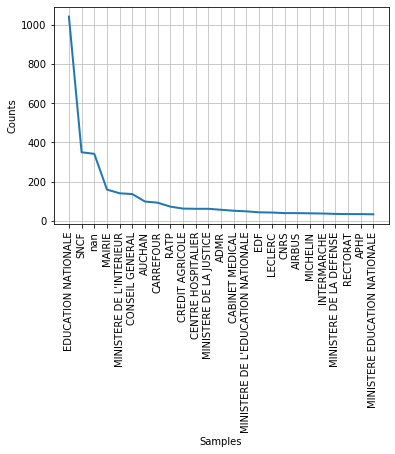

In [47]:
nltk.FreqDist(my_text).plot(25)

## 1.4 Qual

In [48]:
df_rp2014.qual.value_counts(dropna=False)

9.0    13338
1.0     6623
8.0     4712
8.5     2660
NaN     2614
2.1      669
2.2      260
Name: qual, dtype: int64

In [49]:
df_rp2014.i_mca_c.value_counts(dropna=False)

E      21759
NaN     5787
D       2341
C        989
Name: i_mca_c, dtype: int64